Model : MobilenetV2
Optimiser : Nadam
learning rate schedular : cosine aneling
self attention used 
batchnormalization and dropout 


In [30]:
img_h, img_w = 224, 224
batch_size = 32
num_folds = 5

target_path = '/kaggle/input/ph2-skincancer-data-ayush/PH2_train_80_test_20_multi_class'
train_path = f'{target_path}/Train'
test_path = f'{target_path}/Test'
save_model_path = f'/kaggle/working/'
csv_save_dir = f'{target_path}/csv'
    

In [31]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(rescale=1.0 / 255)
test_data = datagen_test.flow_from_directory(
    test_path,
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode='categorical'
)
    

In [32]:
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

train_paths = [str(p) for p in Path(train_path).rglob('*')]
train_labels = [p.parent.name for p in Path(train_path).rglob('*')]

# Oversample minority classes
ros = RandomOverSampler()
train_paths, train_labels = ros.fit_resample(np.array(train_paths).reshape(-1, 1), train_labels)
train_paths = train_paths.flatten().tolist()

print(f'Number of balanced train images: {len(train_paths)}')
    

In [33]:
def self_attention_layer(input_tensor, attention_units):
    query = layers.Dense(attention_units)(input_tensor)
    key = layers.Dense(attention_units)(input_tensor)
    value = layers.Dense(attention_units)(input_tensor)

    _, height, width, channels = input_tensor.shape

    query = layers.Reshape((height * width, attention_units))(query)
    key = layers.Reshape((height * width, attention_units))(key)
    value = layers.Reshape((height * width, attention_units))(value)

    attention_scores = layers.Dot(axes=[2, 2])([query, key])
    attention_scores = layers.Softmax(axis=-1)(attention_scores)

    attention_output = layers.Dot(axes=[2, 1])([attention_scores, value])
    attention_output = layers.Reshape((height, width, attention_units))(attention_output)

    return attention_output

def build_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze initial layers for efficiency
    for layer in base_model.layers[:200]:  
        layer.trainable = False  

    input_tensor = layers.Input(shape=input_shape)
    x = base_model(input_tensor, training=True)

    attention_output = self_attention_layer(x, attention_units=64)
    x = layers.GlobalAveragePooling2D()(attention_output)

    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    predictions = layers.Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model
    

['ph2-skincancer-data-ayush']

In [34]:
initial_learning_rate = 0.0001
decay_steps = 3000
alpha = 0.00001

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=alpha
)
    

total data: 3
Melanoma
/kaggle/input/ph2-skincancer-data-ayush/PH2_train_80_test_20_multi_class/Train/Melanoma/IMD168.bmp
(576, 767, 3) 255 0
Atypical Nevus
/kaggle/input/ph2-skincancer-data-ayush/PH2_train_80_test_20_multi_class/Train/Atypical Nevus/IMD171.bmp
(576, 767, 3) 255 0
Common Nevus
/kaggle/input/ph2-skincancer-data-ayush/PH2_train_80_test_20_multi_class/Train/Common Nevus/IMD175.bmp
(576, 767, 3) 255 0


<ipython-input-35-ca42b2726a80>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread(pchild)


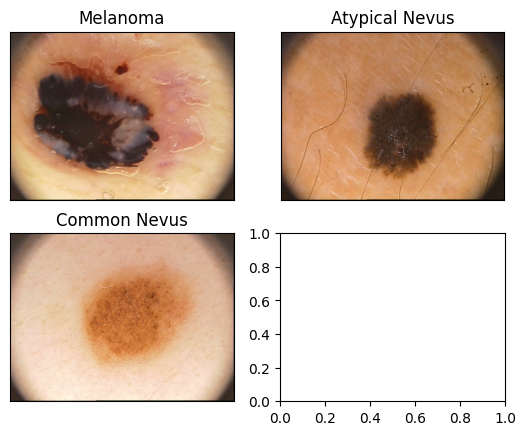

In [35]:
def predict_with_tta(model, img_path, num_augmentations=5):
    img = image.load_img(img_path, target_size=(img_w, img_h))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    predictions = []
    for _ in range(num_augmentations):
        augmented_img = datagen.random_transform(x)
        pred = model.predict(augmented_img)
        predictions.append(pred)

    return a[np.argmax(np.mean(predictions, axis=0))]
    

In [36]:
test_accuracy = []
test_loss = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_paths, train_labels)):
    print(f"\n########### Training Fold {fold+1} ###########")

    y_train = [train_labels[i] for i in train_idx]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    train_gen = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': [train_paths[i] for i in train_idx], 
                                'class': [train_labels[i] for i in train_idx]}),
        x_col="filename",
        y_col="class",
        target_size=(img_h, img_w),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )

    val_gen = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': [train_paths[i] for i in val_idx], 
                                'class': [train_labels[i] for i in val_idx]}),
        x_col="filename",
        y_col="class",
        target_size=(img_h, img_w),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )

    model = build_model(input_shape=(img_h, img_w, 3), num_classes=len(set(train_labels)))
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule), 
                  loss=tfa.losses.SigmoidFocalCrossEntropy(), 
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping], class_weight=class_weight_dict)

    test_x = []
    test_y = []
    test_pred = []
    for label in ['Atypical Nevus', 'Common Nevus', 'Melanoma']:
        directory_path = Path(f'{test_path}/{label}')
        image_files = list(directory_path.glob('*'))
        test_x += [str(i) for i in image_files]
        test_y += [label] * len(image_files)

    test_pred = [predict_with_tta(model, j) for j in test_x]
    loss, acc = model.evaluate(test_data)

    print("Test Accuracy (by manual)", accuracy_score(test_pred, test_y))
    print("Test Accuracy (model.eval)", acc)
    print("Confusion Matrix (by manual):\n", confusion_matrix(test_pred, test_y))

    test_accuracy.append(acc)
    test_loss.append(loss)

print("\n########### Training Completed ###########")
    

Found 40 images belonging to 3 classes.


In [37]:
# K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Get image paths and labels
train_paths = [str(p) for p in Path(train_path).rglob('*')]  # Adjust the file type if necessary (e.g., '*.png')
train_labels = [p.parent.name for p in Path(train_path).rglob('*')] # Label is the parent folder name

t=[[train_paths[i],train_labels[i]] for i in range(len(train_paths))]
import random
random.shuffle(t)
train_paths=[i[0] for i in t]
train_labels=[i[1] for i in t]

# Ensure labels and paths match
print(f'Number of train images: {len(train_paths)}')
print(f'Number of train labels: {len(train_labels)}')



Number of train images: 163
Number of train labels: 163


In [38]:
# Define Self-Attention Layer
def self_attention_layer(input_tensor, attention_units):
    query = layers.Dense(attention_units)(input_tensor)
    key = layers.Dense(attention_units)(input_tensor)
    value = layers.Dense(attention_units)(input_tensor)

    _, height, width, channels = input_tensor.shape

    query = layers.Reshape((height * width, attention_units))(query)
    key = layers.Reshape((height * width, attention_units))(key)
    value = layers.Reshape((height * width, attention_units))(value)

    attention_scores = layers.Dot(axes=[2, 2])([query, key])
    attention_scores = layers.Softmax(axis=-1)(attention_scores)

    attention_output = layers.Dot(axes=[2, 1])([attention_scores, value])
    attention_output = layers.Reshape((height, width, attention_units))(attention_output)

    return attention_output

# Build Model with Self-Attention
def build_model(input_shape, num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = True  # Fine-tune all layers

    input_tensor = layers.Input(shape=input_shape)
    x = base_model(input_tensor, training=True)

    # Self-Attention Layer
    attention_output = self_attention_layer(x, attention_units=64)
    x = layers.GlobalAveragePooling2D()(attention_output)

    # Fully Connected Layers
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(3, activation='softmax')(x)
    model = Model(inputs=input_tensor, outputs=predictions)
    return model

In [39]:
# cosine aniline lr

import tensorflow as tf
initial_learning_rate = 0.0001  # Start with 0.01
decay_steps = 3000  # Decay over 3000 steps
alpha = 0.00001  # Minimum learning rate

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    alpha=alpha,  # Minimum LR as a fraction of initial LR
    warmup_target=0.00001
)

In [40]:
a=['Atypical Nevus','Common Nevus','Melanoma']

def pred(img_path):
  pred_datagen = ImageDataGenerator(
    rescale=1./255)

  img = image.load_img(img_path, target_size=(img_w, img_h))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  x = pred_datagen.standardize(x)
  get_features = model.predict(x)
  # Get the index of the predicted class (highest probability)
  predicted_class_index = np.argmax(get_features)
  # Get the corresponding class label from train_data.class_indices
  predicted_class_label = a[predicted_class_index]

  return predicted_class_label  # Return the predicted class label

In [41]:
from tensorflow.keras.preprocessing import image
from pathlib import Path
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
# print(train_paths)

In [ ]:
# K-Fold Cross-Validation
test_accuracy=[]
test_loss=[]

from sklearn.utils.class_weight import compute_class_weight

for fold, (train_idx, val_idx) in enumerate(skf.split(train_paths, train_labels)):
    print(f"\n########### Training Fold {fold+1} ###########")

    # aweighted classes
    y_train=[train_labels[i] for i in train_idx]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Prepare the train and validation data
    train_gen = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': [train_paths[i] for i in train_idx], 
                                'class': [train_labels[i] for i in train_idx]}),
        x_col="filename",
        y_col="class",
        target_size=(img_h, img_w),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=True
    )

    val_gen = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': [train_paths[i] for i in val_idx], 
                                'class': [train_labels[i] for i in val_idx]}),
        x_col="filename",
        y_col="class",
        target_size=(img_h, img_w),
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False
    )


    

    # Build & Compile Model
    model = build_model(input_shape=(img_h, img_w, 3), num_classes=len(set(train_labels)))
    model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

    # Train Model
    model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks=[early_stopping],class_weight=class_weight_dict)

    # Evaluate Model


    

    test = dict()
    a=['Atypical Nevus','Common Nevus','Melanoma']
    for p in a:
      directory_path = Path(f'{test_path}/{p}')
      image_files = list(directory_path.glob('*'))
      test[p] = [str(i) for i in image_files]


    test_x = []
    test_y = []
    test_pred = []
    for i in a:
      test_x += test[i]
      test_y += [i] * len(test[i])
    test_pred = [pred(j) for j in test_x]
    loss,acc=model.evaluate(test_data)
    print("test accuracy(by manual)", accuracy_score(test_pred, test_y))
    print("test accuracy(model.eval)", acc)
    print("Confusion Matrix(by manual):\n", confusion_matrix(test_pred, test_y))
    test_accuracy+=[acc]
    test_loss+=[loss]  



print("\n########### Training Completed ###########")



########### Training Fold 1 ###########


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Found 127 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 33 validated image filenames belonging to 3 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 340s 48s/step - accuracy: 0.2605 - loss: 7.9520 - val_accuracy: 0.2424 - val_loss: 7.4971
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.2805 - loss: 7.7242 - val_accuracy: 0.2727 - val_loss: 7.4958
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.2953 - loss: 7.7411 - val_accuracy: 0.2424 - val_loss: 7.4905
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.3404 - loss: 7.7085 - val_accuracy: 0.2424 - val_loss: 7.4847
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.3541 - loss: 7.6922 - val_accuracy: 0.2727 - val_loss: 7.4736
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.2578 - loss: 7.7712 - val_accuracy: 0.2727 - val_loss: 7.4574
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.3219 - loss: 7.5966 - val_accuracy: 0.3030 - val_loss: 7.4403
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.3845 - loss: 7.4854 - val_accuracy: 0.3030 - val_loss: 7.4196
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 255s 34s/step - accuracy: 0.3592 - loss: 7.6190 - val_accuracy: 0.3939 - val_loss: 7.3392
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 307ms/step - accuracy: 0.3727 - loss: 7.5437 - val_accuracy: 0.4242 - val_loss: 7.3337
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.3738 - loss: 7.6116 - val_accuracy: 0.4545 - val_loss: 7.3212
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.3720 - loss: 7.4770 - val_accuracy: 0.4848 - val_loss: 7.3145
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 0.3394 - loss: 7.6162 - val_accuracy: 0.5152 - val_loss: 7.3095
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - accuracy: 0.4013 - loss: 7.4567 - val_accuracy: 0.5455 - val_loss: 7.3005
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.4428 - loss: 7.4662 - val_accuracy: 0.5152 - val_loss: 7.2919
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.4107 - loss: 7.3675 - val_accuracy: 0.5152 - val_loss: 7.2904
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.3385 - loss: 7.7654 - val_accuracy: 0.4062 - val_loss: 7.3500
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step - accuracy: 0.3938 - loss: 7.5911 - val_accuracy: 0.4688 - val_loss: 7.3419
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.4052 - loss: 7.5599 - val_accuracy: 0.4688 - val_loss: 7.3329
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 244ms/step - accuracy: 0.2604 - loss: 7.7592 - val_accuracy: 0.3750 - val_loss: 7.3317
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.3562 - loss: 7.6762 - val_accuracy: 0.3750 - val_loss: 7.3338
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 234ms/step - accuracy: 0.3833 - loss: 7.5694 - val_accuracy: 0.3750 - val_loss: 7.3319
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step - accuracy: 0.4000 - loss: 7.6268 - val_accuracy: 0.3750 - val_loss: 7.3294
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 255s 25s/step - accuracy: 0.2302 - loss: 8.1463 - val_accuracy: 0.1935 - val_loss: 7.5661
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.3327 - loss: 7.7986 - val_accuracy: 0.1935 - val_loss: 7.5619
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.3355 - loss: 7.7272 - val_accuracy: 0.1935 - val_loss: 7.5645
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.3663 - loss: 7.5538 - val_accuracy: 0.1935 - val_loss: 7.5725
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.3406 - loss: 7.7090 - val_accuracy: 0.2258 - val_loss: 7.5796
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.4010 - loss: 7.4168 - val_accuracy: 0.2258 - val_loss: 7.5888
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.3949 - loss: 7.5458 - val_accuracy: 0.2258 - val_loss: 7.5988
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.4143 - loss: 7.4941 - val_accuracy: 0.2258 - val_loss: 7.5938
Epo

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [ ]:
# Save the model path
model_save_path = f"{save_model_path}/xception_self_attention_fold_{fold+1}.h5"
# Save the model
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

In [ ]:
acc1=0
loss1=0
for  i in test_accuracy:
    acc1+=i
for i in test_loss:
    loss1+=i
acc1/=5
loss1/=5

In [ ]:
print(f"After 5 fold cross validation test accuracy:{acc1} loss:{loss1}")

In [ ]:
##end

In [ ]:
pred = np.argmax(model.predict(test_data), axis=1)
test_y = test_data.labels
print("Predictions:", pred)

In [ ]:
# Initialize lists to store accuracy and losses
fold_accuracies = []
fold_losses = []


In [ ]:
# Calculate accuracy and confusion matrix
accuracy = model.evaluate(test_data)[1]
fold_accuracies.append(accuracy)

print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
print("Confusion Matrix:\n", confusion_matrix(test_y, pred))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(test_y, pred)
print(f'Accuracy: {accuracy}')

print("Confusion Matrix:\n", confusion_matrix(test_y, pred))

In [ ]:
# Plot training and validation metrics
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history.get('accuracy')
val_acc = hist.history.get('val_accuracy')

epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()
